In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [2]:
!git clone https://github.com/google-research/bleurt.git
%cd bleurt
!pip install .

Cloning into 'bleurt'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 134 (delta 0), reused 17 (delta 0), pack-reused 116 (from 1)
Receiving objects: 100% (134/134), 31.28 MiB | 49.50 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/bleurt
Processing /content/bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456766 sha256=6980b9e6525e8601348daeca768576ce70698906c1e72ec8aa2ff3a6c5939fb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7cujr_2/wheels/49/ab/73/9318ab38d4cd1c732bcea8335d3f8d7c0316c8d07b9084fa85
Successfully built BLEURT


In [3]:
!pip install -q evaluate rouge_score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00


In [4]:
import json
import time
import os
import pandas as pd
import numpy as np
import re
from copy import deepcopy

In [5]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# !python -m unittest bleurt.score_test
# !python -m unittest bleurt.score_not_eager_test
# !python -m unittest bleurt.finetune_test
# !python -m unittest bleurt.score_files_test

In [6]:
from bleurt import score
from evaluate import load as load_metric

In [7]:
rouge = load_metric("rouge")
bertscore = load_metric("bertscore")
bleurt = load_metric("bleurt", module_type="metric")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load generations

In [10]:
fine_tune_path = '/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM'
model_name = 'bart' # ADJUST
sub_model_name = 'bio_bart' # ADJUST
checkpoints_dir = f"{fine_tune_path}/{model_name}/{sub_model_name}/lora_1" # ADJUST
checkpoints_path = f"{checkpoints_dir}/checkpoints"
final_checkpoints_path = f"{checkpoints_dir}/final_checkpoints"
eval_path = f"{checkpoints_dir}/eval_{sub_model_name}.csv"

In [11]:
eval_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/bart/bio_bart/lora_1/eval_bio_bart.csv'

In [12]:
checkpoints_dir

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/bart/bio_bart/lora_1'

In [13]:
test_soap_50_df = pd.read_csv(f"{checkpoints_dir}/test_soap_50.csv")
# test_soap_50_100_df = pd.read_csv(f"{checkpoints_dir}/test_soap_50_100.csv")
# # train_soap_50_df = pd.read_csv(f"{checkpoints_dir}/train_soap_50.csv")
# mts_50_df = pd.read_csv(f"{checkpoints_dir}/mts_50.csv")
# aci_50_df = pd.read_csv(f"{checkpoints_dir}/aci_50.csv")

In [14]:
print(len(test_soap_50_df))
test_soap_50_df.head(3)

50


,dialogue,reference_note,fine_tuned_model_output
0,"Doctor: Hello, can you please tell me about yo...","S: The patient, a flooring installer with no s...","S: The patient, a flooring installer, reports ..."
1,"Doctor: Hello, I understand that you're a 7-ye...",S: The patient is a 7-year-old boy with congen...,"S: The patient, a 7-year-old boy with congenit..."
2,"Doctor: Hello, we've received your results fro...",S: The patient reported undergoing an ultrasou...,S: The patient reports a single thyroid nodule...


# Evaluate on MTS-Dialog

## Testing

In [15]:
def evaluate_clinical_summary(generated_text: str, reference_text: str) -> dict:
    predictions = [generated_text]
    references = [reference_text]

    # ROUGE
    rouge_scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    # BERTScore
    bert_scores = bertscore.compute(predictions=predictions, references=references, lang="en")
    bert_precision = sum(bert_scores['precision']) / len(bert_scores['precision'])
    bert_recall = sum(bert_scores['recall']) / len(bert_scores['recall'])
    bert_f1 = sum(bert_scores['f1']) / len(bert_scores['f1'])

    # BLEURT
    bleurt_score = bleurt.compute(predictions=predictions, references=references)['scores'][0]

    # # QuestEval
    # questeval_score = questeval.compute(hypothesis=generated_text, reference=reference_text, do_weighing=False)['questeval_score']

    return {
        "ROUGE-1": round(rouge_scores['rouge1'], 4),
        "ROUGE-2": round(rouge_scores['rouge2'], 4),
        "ROUGE-L": round(rouge_scores['rougeL'], 4),
        "ROUGE-LSum": round(rouge_scores['rougeLsum'], 4),
        "BERTScore-P": round(bert_precision, 4),
        "BERTScore-R": round(bert_recall, 4),
        "BERTScore-F1": round(bert_f1, 4),
        "BLEURT": round(bleurt_score, 4),
        # "QuestEval": round(questeval_score, 4)
    }

In [16]:
evaluate_clinical_summary("This is a test", "This is a test")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'ROUGE-1': np.float64(1.0),
 'ROUGE-2': np.float64(1.0),
 'ROUGE-L': np.float64(1.0),
 'ROUGE-LSum': np.float64(1.0),
 'BERTScore-P': 1.0,
 'BERTScore-R': 1.0,
 'BERTScore-F1': 1.0,
 'BLEURT': 1.0118}

In [ ]:
test_soap_50_df.iloc[0]["reference_note"]

"S: The patient, a flooring installer with no significant past medical history, presents with painless blurry vision in the right eye for one week, intermittent fevers, headaches, body aches, and a nonpruritic maculopapular rash on the lower legs for six months. The patient also reports an isolated episode of left knee and testicular swelling in the past but denies any neck stiffness, nausea, vomiting, Raynaud's phenomenon, oral ulcerations, chest pain, shortness of breath, abdominal pain, or photosensitivity. No history of exposure to toxic substances or habits related to smoking, drinking, or illicit drug use.\nO: Vital signs are normal. Physical examination reveals bilateral papilledema, greater optic nerve erythema in the right eye, a right inferior nasal quadrant visual field defect, and a right afferent pupillary defect. Muscle strength, reflexes, and sensation to light touch, pinprick, vibration, and proprioception are intact. A maculopapular rash is noted on bilateral lower ext

In [ ]:
test_soap_50_df.iloc[0]["fine_tuned_model_output"]

"S: The patient, a flooring installer, reports painless blurry vision in the right eye for a week, intermittent fevers, headache, body aches, and a nonpruritic maculopapular rash on the lower legs for the past 6 months. He denies any toxic substances, smoking, drinking, or illicit drug use. He also reports an isolated episode of left knee swelling and testicular swelling in the past. O: Vital signs were normal. Physical examination revealed bilateral papilledema and optic nerve in the right eye, with a right inferior nasal quadrant visual field defect and a right a pupillary defect. Muscle strength and reflexes were normal. Muscle strength and reflexes were intact. Laboratory findings included microcytism with a magnitude of 11.6 g/dL, hematocrit of 35.3%, and mean corpuscular volume of 76.9 fL. ESR was elevated at 33 mm/hr, and C-reactive protein (CRP) was elevated at 13.3 mg/L. A: The primary diagnosis is a systemic inflammatory process, likely infectious, with potential implications

In [17]:
evaluate_clinical_summary(test_soap_50_df.iloc[0]["reference_note"], test_soap_50_df.iloc[0]["fine_tuned_model_output"])

{'ROUGE-1': np.float64(0.6418),
 'ROUGE-2': np.float64(0.3646),
 'ROUGE-L': np.float64(0.4856),
 'ROUGE-LSum': np.float64(0.5603),
 'BERTScore-P': 0.8957,
 'BERTScore-R': 0.9221,
 'BERTScore-F1': 0.9087,
 'BLEURT': 0.3769}

In [18]:
evaluate_clinical_summary(test_soap_50_df.iloc[1]["reference_note"], test_soap_50_df.iloc[1]["fine_tuned_model_output"])

{'ROUGE-1': np.float64(0.4356),
 'ROUGE-2': np.float64(0.1652),
 'ROUGE-L': np.float64(0.2711),
 'ROUGE-LSum': np.float64(0.3867),
 'BERTScore-P': 0.8785,
 'BERTScore-R': 0.8396,
 'BERTScore-F1': 0.8586,
 'BLEURT': -0.3206}

## Sequential

In [ ]:
def evaluate_sequentially(df):
    results = []

    for idx, sample in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
        dialogue = sample["dialogue"]
        reference_summary = sample["reference summary"]
        generated_summary = sample["generated summary"]

        metrics = evaluate_clinical_summary(generated_summary, reference_summary)

        results.append({
            "dialogue": dialogue,
            "reference_summary": reference_summary,
            "generated_summary": generated_summary,
            **metrics
        })

    return pd.DataFrame(results)

In [ ]:
eval_test_soap_50_df = evaluate_sequentially(test_soap_50_df)
eval_test_soap_50_df.to_csv(f"{checkpoints_dir}/eval_test_soap_50.csv", index=False)

## Parallel

In [19]:
# Parallel
def evaluate_in_batch(df, batch_size=16):
    results = []

    for start in tqdm(range(0, len(df), batch_size), desc="Evaluating in batches"):
        batch = df.iloc[start:start+batch_size]
        preds = batch["fine_tuned_model_output"].tolist()
        refs = batch["reference_note"].tolist()
        diags = batch["dialogue"].tolist()

        # Compute metrics
        # rouge_scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
        bert_scores = bertscore.compute(predictions=preds, references=refs, lang="en", device="cuda")
        bleurt_scores = bleurt.compute(predictions=preds, references=refs)

        for i in range(len(preds)):
          # ROUGE must be computed per example
            rouge_score = rouge.compute(predictions=[preds[i]], references=[refs[i]], use_stemmer=True)

            results.append({
                "dialogue": diags[i],
                "reference_summary": refs[i],
                "generated_summary": preds[i],
                "ROUGE-1": round(rouge_score['rouge1'], 4),
                "ROUGE-2": round(rouge_score['rouge2'], 4),
                "ROUGE-L": round(rouge_score['rougeL'], 4),
                "ROUGE-LSum": round(rouge_score['rougeLsum'], 4),
                "BERTScore-P": round(bert_scores['precision'][i], 4),
                "BERTScore-R": round(bert_scores['recall'][i], 4),
                "BERTScore-F1": round(bert_scores['f1'][i], 4),
                "BLEURT": round(bleurt_scores['scores'][i], 4),
            })

    return pd.DataFrame(results)

In [20]:
eval_test_soap_50_df = evaluate_in_batch(test_soap_50_df, batch_size=16)
eval_test_soap_50_df.to_csv(f"{checkpoints_dir}/eval_test_soap_50.csv", index=False)

Evaluating in batches: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


In [21]:
eval_test_soap_50_df

,dialogue,reference_summary,generated_summary,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-LSum,BERTScore-P,BERTScore-R,BERTScore-F1,BLEURT
0,"Doctor: Hello, can you please tell me about yo...","S: The patient, a flooring installer with no s...","S: The patient, a flooring installer, reports ...",0.6418,0.3646,0.4856,0.5705,0.9221,0.8957,0.9087,0.3513
1,"Doctor: Hello, I understand that you're a 7-ye...",S: The patient is a 7-year-old boy with congen...,"S: The patient, a 7-year-old boy with congenit...",0.4356,0.1652,0.2711,0.3644,0.8396,0.8785,0.8586,-0.3280
2,"Doctor: Hello, we've received your results fro...",S: The patient reported undergoing an ultrasou...,S: The patient reports a single thyroid nodule...,0.5832,0.2763,0.3368,0.4969,0.9013,0.8930,0.8971,-0.3351
3,"Doctor: Hello, can you tell me what brought yo...","S: The patient reports a progressive headache,...","S: The patient reports a progressive headache,...",0.6512,0.3738,0.4977,0.5907,0.9161,0.9038,0.9099,0.0354
4,"Doctor: Hello, I uh understand that you have h...","S: The patient, a post-liver transplant recipi...","S: The patient, a liver transplant recipient w...",0.5926,0.2751,0.3074,0.5074,0.8951,0.8927,0.8939,-0.1535
5,"Doctor: Hello, how can I help you today?\nPati...","S: The patient, a non-smoker and engineer, rep...","S: The patient, a non-smoker, reports experien...",0.5447,0.3195,0.4096,0.4837,0.9042,0.8845,0.8942,-0.1171
6,"Doctor: Hi there, I see you've presented with ...",S: The patient presented with body weight loss...,S: The patient presents with body weight loss....,0.6150,0.3518,0.4300,0.5350,0.9161,0.8872,0.9014,0.1385
7,"Doctor: Hello, I heard you have a 6-month hist...",S: The patient reports a 6-month history of sw...,S: The patient reports a 6-month history of sw...,0.6398,0.4190,0.4929,0.5735,0.9335,0.9024,0.9177,-0.1422
8,"Doctor: Hi there, can you please tell me about...","S: The patient, a male with a history of prost...","S: The patient, a prostate cancer patient, rep...",0.7094,0.3792,0.4207,0.5134,0.9172,0.9097,0.9134,0.2622
9,"Doctor: Hello, how can I I help you today?\nPa...",S: The patient is a 76-year-old woman presenti...,Sixty-six-year-old female with hypertension an...,0.5576,0.3194,0.3917,0.4700,0.9132,0.8724,0.8923,-0.3292


In [22]:
def calculate_average_metrics(df):
    metrics = [
        'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-LSum',
        'BERTScore-P', 'BERTScore-R', 'BERTScore-F1', 'BLEURT'
    ]
    avg_scores = {metric: df[metric].mean() for metric in metrics}
    return avg_scores

In [23]:
def display_evaluation(average_scores):
    print("Average Evaluation Metrics:")
    for metric, score in average_scores.items():
        print(f"{metric}: {score:.4f}")

In [24]:
eval_test_soap = calculate_average_metrics(eval_test_soap_50_df) # modified soap summary

In [25]:
display_evaluation(eval_test_soap)

Average Evaluation Metrics:
ROUGE-1: 0.6140
ROUGE-2: 0.3367
ROUGE-L: 0.4014
ROUGE-LSum: 0.5275
BERTScore-P: 0.9077
BERTScore-R: 0.8963
BERTScore-F1: 0.9019
BLEURT: -0.0425


In [33]:
checkpoints_path = f"{checkpoints_dir}/checkpoints/dialogue-summary-training-2025-06-19_06-03-00/checkpoint-219"

In [34]:
checkpoints_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/bart/bio_bart/lora_1/checkpoints/dialogue-summary-training-2025-06-19_06-03-00/checkpoint-219'

In [35]:
# Load trainer_state.json
trainer_state_path = os.path.join(checkpoints_path, "trainer_state.json")
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    # Print training and evaluation metrics
    for log in trainer_state["log_history"]:
        step = log.get("step", "N/A")
        train_loss = log.get("loss", "N/A")
        eval_loss = log.get("eval_loss", "N/A")
        print(f"Step {step}: Train Loss = {train_loss}, Eval Loss = {eval_loss}")
else:
    print("No trainer_state.json found. Check if training completed successfully.")

Step 100: Train Loss = 1.7811, Eval Loss = N/A
Step 200: Train Loss = 1.171, Eval Loss = N/A


In [37]:
import matplotlib.pyplot as plt

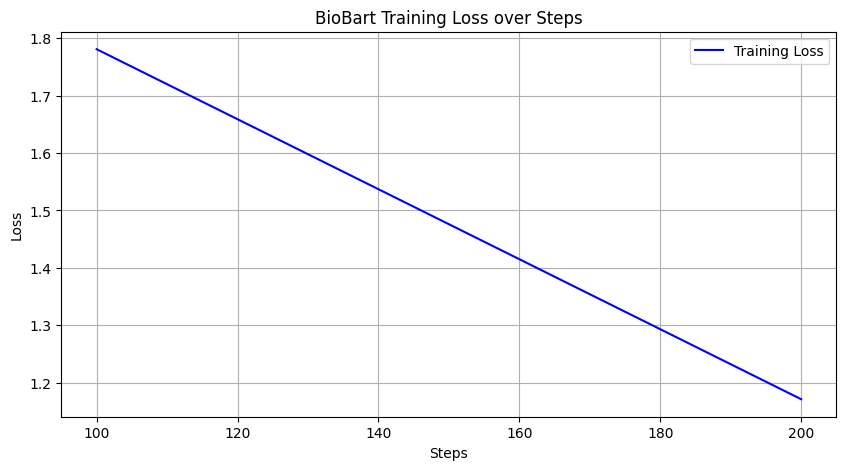

In [39]:
steps = []
train_losses = []

if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    for log in trainer_state["log_history"]:
        step = log.get("step")
        if "loss" in log:
            steps.append(step)
            train_losses.append(log["loss"])

    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_losses, label="Training Loss", color='blue')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("BioBart Training Loss over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found.")